# Image classification CNN

In this lab we will train a convolution neural network for image classification from scratch. 
You will implement a CNN, a training and a validation loop, a custom dataset loader and a couple of helper functions.

## Speed and hardware
Image classification CNN training is typically done on GPUs, often multiple ones, as the process is very computationally intensive. 
This assignment, on the other hand, is created to be run on a CPU: a single training epoch takes 1-5 minutes, depending on the CNN architecture and hardware. 

Specifically, it takes 90 sec for training an epoch on the laptop i7 CPU and 26 sec on the mobile GT940M GPU.
Another option is to use [Google Colab](https://colab.research.google.com/). In the latter case, you will find comments with additional commands to run. Also, all the data (saved networks, datasets) will be auto-deleted after the end of the runtime session, so make sure to download the results of the training.

In [1]:
# FOR COLAB: uncomment and run the following code every time you are starting the session
#!pip install kornia

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
from tqdm import tqdm_notebook as tqdm
from time import time

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

First, let's download the data. 

**Imagenette** is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute). 

The subset is created by [Jeremy Howard](https://twitter.com/jeremyphoward) and available at https://github.com/fastai/imagenette


In [3]:
# FOR COLAB: uncomment and run the following code every time you are starting the session
# for local: uncomment and run once
#import urllib.request

#url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
#filename = "imagenette2-160.tgz"

#urllib.request.urlretrieve(url, filename)
#!tar -xzf imagenette2-160.tgz

# Dataset and DataLoader 

Now, let's create dataset and data loaders. Dataset is an object, which contains training samples (or can read/generate them on the fly) and all necessary additional information. Data loader is an object, which takes samples from the dataset and generates the batch in efficient way.

For more details, see here 
https://pytorch.org/docs/stable/data.html and here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

There are also several classes for the most common use-cases, in torchvision module:
https://pytorch.org/docs/stable/torchvision/datasets.html


We will use [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class. It assumes that data is already structured like this 'datasetroot/class1/images": 

    root/dog/xxy.jpg
    root/dog/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png

We need to specify two input parameters: path to the root directory and transform. Transform takes PIL.Image and outputs torch.tensor. It can also do some data modification: augmentation, normalization and so on. Let's do it on example. 
We will resize our data to 128x128 px size, transform to tensor and normalize them to have zero mean and unit variance. 
Your first task is to write function `get_dataset_statistics`, which takes a dataset object and return its mean and std (pixel-wise). Remember, that you have to calculate the statistics **only** on training set, not validation or test sets.

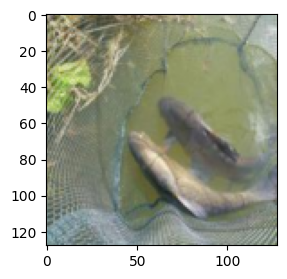

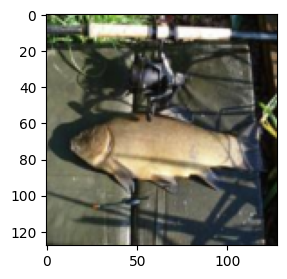

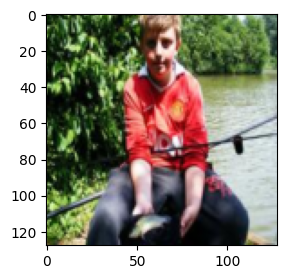

In [4]:
import torchvision.transforms as tfms
train_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.ToTensor()])


ImageNette_for_statistics = tv.datasets.ImageFolder('imagenette2-160/train', 
                                    transform = train_transform,)

for i in range(3):
    imshow_torch(ImageNette_for_statistics[i][0], figsize=(3,3))

In [5]:
from cnn_training import get_dataset_statistics
torch.set_default_device('cuda:0')

mean, std = get_dataset_statistics(ImageNette_for_statistics)
# mean, std = [0.46248055, 0.4579692, 0.42981696], [0.27553096, 0.27220666, 0.295335]
print (mean, std)

[0.46247661113739014, 0.45796719193458557, 0.4298022985458374] [0.22812697291374207, 0.22238846123218536, 0.2307228446006775]


In [6]:
for data in ImageNette_for_statistics:
    break
print (data[0].shape)

torch.Size([3, 128, 128])


Now lets create the transform and datasets for training, which include [input normalization](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn). To avoid overfitting, we may include slight data augmentation into training transform: random cropping and random horizontal flip.


In [7]:
train_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.RandomHorizontalFlip(),
                                tfms.ToTensor(),
                                tfms.Normalize(mean, std)])

val_transform = tfms.Compose([tfms.Resize((128,128)),
                            tfms.ToTensor(),
                            tfms.Normalize(mean, std)])


ImageNette_train = tv.datasets.ImageFolder('imagenette2-160/train',
                                          transform = train_transform)                       

ImageNette_val = tv.datasets.ImageFolder('imagenette2-160/val', 
                                    transform = val_transform)

In [8]:
train_transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.46247661113739014, 0.45796719193458557, 0.4298022985458374], std=[0.22812697291374207, 0.22238846123218536, 0.2307228446006775])
)

Now lets create data loaders. The most important parameters are batch size (number of samples in the mini-batch), number of workers (good idea to match them to number of cores of your CPU or less.

In [9]:
# Taken from here https://stackoverflow.com/a/58748125/1983544
import os
num_workers = os.cpu_count() 
if 'sched_getaffinity' in dir(os):
    num_workers = len(os.sched_getaffinity(0)) - 2
print (num_workers)

16


On GPU, the bigger batchsize, the more efficient is training. On the other hand, smaller batch_size may lead to better results in terms of final accuracy. The selection of the proper batch size and other parameters depending on it, is an active research area. We will take the batch of 32. Feel free to adjust it according to your hardware and memory amount.

In [10]:
BS = 32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dl = torch.utils.data.DataLoader(ImageNette_train,
                                      batch_size= 32,
                                       shuffle = True, # important thing to do for training. 
                                       num_workers = num_workers,
                                        generator=torch.Generator(device=device))
val_dl = torch.utils.data.DataLoader(ImageNette_val,
                                      batch_size= 32,
                                     shuffle = False,
                                     num_workers = num_workers,
                                     drop_last=False,
                                     generator=torch.Generator(device=device)) 
#drop_last means "drop last batch from the dataset.
# if it is smaller than required batch size. Might be good thing to do for training, but not for validation.

In [11]:
# from tqdm import tqdm
# from time import time
# t = time()
# for data, labels in tqdm(train_dl):
#     break
# print (data.shape, labels.shape, data.device)

In [12]:
# for data, labels in tqdm(val_dl):
#     break
# print (data.shape, labels.shape, data.device)

```python
for data, labels in train_dl:
    break
print (data.shape, labels.shape)
```

    torch.Size([32, 3, 128, 128]) torch.Size([32])

Now, lets define a model. It should consist of convolution, non-linearity, pooling, batch-norm layers. And finish with a classifier. It is your task to experiment and find a good model. We will show VGG-style model.

Papers to look for inspiration: 
- [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
- [VGGNet](https://arxiv.org/pdf/1409.1556)
- [Systematic Evaluation of Convolution Neural Network Advances on the ImageNet](https://arxiv.org/pdf/1606.02228).
- [ResNet](https://arxiv.org/abs/1512.03385)
- [Bag of tricks](https://arxiv.org/abs/1812.01187)
- [Compounding the Performance Improvements of Assembled Techniques
in a Convolutional Neural Network](https://arxiv.org/pdf/2001.06268.pdf)


But remember that models above are quite beefy, so one may need something lighter for the current task. 

**Important: you need to define your own model, the default one is not enough to pass the assignment**

In [13]:
from cnn_training import SimpleCNN

num_classes = len(ImageNette_train.classes)
model = SimpleCNN(num_classes)

print (model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (5): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (14): BatchNorm2d(128, eps=1e-05, mom

Now you need to initialize weights of the convolution and linear layers. Good idea would be to use kaiming initialization of scaled orthonormal initialization
https://pytorch.org/docs/stable/nn.init.html

Write a function `weight_init`, which fill the weights with proper random values.

In [14]:
from cnn_training import weight_init

model.features.apply(weight_init)
model.clf.apply(weight_init)


Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=10, bias=True)
)

Now let's write a training loop function `train_and_val_single_epoch`. It should set the model to train mode by model.train(), 
create an optimizer, go through samples in training loader, calculate the loss function and apply the gradients.

https://pytorch.org/docs/stable/optim.html

The simplified version, as shown in pytorch tutorial is as following:

```python3
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
validate(model, val_loader, loss_fn)
```

As optimizer is it good idea to take AdamW or SGD. Loss function for classification: CrossEntropyLoss

In [15]:
from cnn_training import train_and_val_single_epoch
help (train_and_val_single_epoch)

Help on function train_and_val_single_epoch in module cnn_training:

train_and_val_single_epoch(model: torch.nn.modules.module.Module, train_loader: torch.utils.data.dataloader.DataLoader, val_loader: torch.utils.data.dataloader.DataLoader, optim: torch.optim.optimizer.Optimizer, loss_fn: torch.nn.modules.module.Module, epoch_idx=0, lr_scheduler=None, writer=None, device: torch.device = device(type='cpu'), additional_params: Dict = {}) -> torch.nn.modules.module.Module
    Function, which runs training over a single epoch in the dataloader and returns the model. Do not forget to set the model into train mode and zero_grad() optimizer before backward.


In the similar fashion implement `validate` function

In [16]:
from cnn_training import validate
help (validate)

Help on function validate in module cnn_training:

validate(model: torch.nn.modules.module.Module, val_loader: torch.utils.data.dataloader.DataLoader, loss_fn: torch.nn.modules.module.Module, device: torch.device = device(type='cpu'), additional_params: Dict = {}) -> Tuple[float, Dict]
    Function, which runs the module over validation set and returns accuracy


Now we are almost ready to run the training. What we are lacking, is a learning_rate value. 
A method, which solves this issue for a broad range of architectures, tasks and optimizers is described in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) and [A DISCIPLINED APPROACH TO NEURAL NETWORK
HYPER-PARAMETERS: PART 1 – LEARNING RATE, BATCH SIZE, MOMENTUM, AND WEIGHT DECAY](https://arxiv.org/pdf/1803.09820.pdf) by L. Smith.

The algorithm is as following:

1. Save (on HDD or by deepcopy) the original CNN initialization.
2. Create a sequence of learning rates from min_lr to max_lr in log space (use np.logspace)
3. Start training the network, changing the learning rate after 1, 2 or 3 steps of the gradient descent and record the loss value corresponding to each learning rate in the sequence. **Important: steps == mini-batches, not epochs**. `lr_find` should be much faster, than overall training.
4. (optional, for speed-up) Stop when the loss becomes larger than 10x the initial one.
5. (optional) smooth the loss values.
6. Restore model weights from save (1)
7. Plot the loss and select the value, which is either (a) 3x to 10x smaller than the one, corresponding to the minimum of the loss function, or (b) 3x to 10x times smaller than the one just before loss increase. (a) or (b) is your choice.

Implement this proceduce in the `lr_find` function. Use the same optimizer for the `lr_find`, as for the training.

In [17]:
from cnn_training import lr_find, SimpleCNN, weight_init

num_classes = len(ImageNette_train.classes)
model = SimpleCNN(num_classes)
%reload_ext autoreload

model.features.apply(weight_init)
model.clf.apply(weight_init)
loss_fn = nn.CrossEntropyLoss()
losses, lrs = lr_find(model, train_dl, loss_fn, 1e-7, 100, steps=50)

Getting data:   0%|          | 0/2 [00:00<?, ?it/s]

Data loaded: 45.4 seconds


Finding LR:   0%|          | 0/50 [00:00<?, ?it/s]

Loss at lr=1e-07: 2.2965621948242188
Loss at lr=1e-07: 2.3249006271362305
Loss at lr=1e-07: 2.2631301879882812
Loss at lr=1.5264179671752333e-07: 2.2808356285095215
Loss at lr=1.5264179671752333e-07: 2.333211660385132
Loss at lr=1.5264179671752333e-07: 2.278141975402832
Loss at lr=2.329951810515372e-07: 2.29508113861084
Loss at lr=2.329951810515372e-07: 2.3218398094177246
Loss at lr=2.329951810515372e-07: 2.283198595046997
Loss at lr=3.5564803062231287e-07: 2.2909598350524902
Loss at lr=3.5564803062231287e-07: 2.329345703125
Loss at lr=3.5564803062231287e-07: 2.2910618782043457
Loss at lr=5.428675439323859e-07: 2.303112030029297
Loss at lr=5.428675439323859e-07: 2.318979501724243
Loss at lr=5.428675439323859e-07: 2.2684149742126465
Loss at lr=8.286427728546842e-07: 2.295583724975586
Loss at lr=8.286427728546842e-07: 2.323514938354492
Loss at lr=8.286427728546842e-07: 2.2762746810913086
Loss at lr=1.2648552168552959e-06: 2.307079553604126
Loss at lr=1.2648552168552959e-06: 2.32322669029

Now let's plot the learning rates and losses and pick the best value. You can just use plt.semilogx(lrs, losses), but somehow ticks 
are invisible in such a large range, so we will use a solution from stackoverflow.

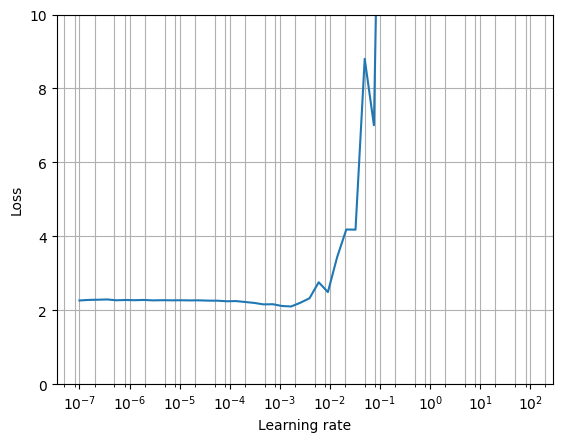

In [18]:
# https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large/44079725#44079725
def plot_lrs_losses(lrs, losses):
    import matplotlib.ticker
    fig, ax=plt.subplots()
    ax.semilogx(lrs, losses)
    ax.set_ylim([0, 10.])
    ax.grid(True, which="both")
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.5, 0.8),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    plt.show()
    return
plot_lrs_losses(lrs, losses)

Here is the plot for AdamW optimizer with exampleCNN 
```python
plot_lrs_losses(lrs, losses)
```
![image.png](training-imagenette-CNN_files/att_00003.png)

And for SGD

![image.png](training-imagenette-CNN_files/att_00000.png)

A good value here would be 1e-3 for AdamW and 3e-3 for SGD with momentum.

We will use [tensorboard](https://www.tensorflow.org/tensorboard) for plotting training and validation statistics. 
It works as follows: the `writer` object writes logs in a specific format as training goes on. 
In a separate console window, run 
```bash
tensorboard --logdir=runs --port=6006
```

And open [localhost:6006](http://localhost:6006/) in a separate browser window.

To add a value to tensorboard, one needs to use function add_scalar.
For detailed reference see https://pytorch.org/docs/stable/tensorboard.html


```python
writer.add_scalar("Loss/val", loss.item(), epoch_idx)
```

If you are running on Google Colab, you can open tensorboard in the cell:


```python
%load_ext tensorboard
%tensorboard --logdir runs
```

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [20]:
torch.ones(9).device

device(type='cuda', index=0)

In [21]:
# FOR COLAB: uncomment and run the following code every time you are starting the session.
# You can monitor the training here
#%load_ext tensorboard
#%tensorboard --logdir runs

In [22]:
from cnn_training import train_and_val_single_epoch, SimpleCNN
from torch.utils.tensorboard import SummaryWriter

model = SimpleCNN(10)


model.features.apply(weight_init)
model.clf.apply(weight_init)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(comment="AdamW_no_scheduler") #Comment is a name for graph (see screenshot below)

Split to continue training if desired

Screenshot from tensorboard for the SGD
![image.png](training-imagenette-CNN_files/att_00001.png)

Screenshot from tensorboard for the AdamW
![image.png](training-imagenette-CNN_files/att_00004.png)

A good idea would be to use a learning rate scheduler i.e. not keeping the learning rate constant, but changing it  on the fly. See the different learning rate schedules example (from [Systematic Evaluation of Convolution Neural Network Advances on the ImageNet](https://arxiv.org/pdf/1606.02228) paper).

![image.png](training-imagenette-CNN_files/att_00002.png)

Lets compare no-schedule (above) with one-cycle.
Good schedules to try will be one-cycle policy, step-policy, linear policy.
See an example here:
https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [32]:
from torch.optim.lr_scheduler import OneCycleLR
from cnn_training import *
from torch.utils.tensorboard import SummaryWriter

loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Re-init the model
model = SimpleCNN(10)
model.features.apply(weight_init)
model.clf.apply(weight_init)
epochs = 5
start_epoch = 0
writer = SummaryWriter(comment="AdamW_OneCycleSched") 
lr_sched = OneCycleLR(opt1, max_lr=3e-3, steps_per_epoch=len(train_dl), epochs=epochs)

for ep in range(start_epoch, start_epoch + epochs):
    t=time()
    model_filename = f'models/fixed_at_{ep}'
    try:
        torch.load(model_filename)
    except FileNotFoundError:
        opt1 = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, eps=1e-2)
        model = train_and_val_single_epoch(model, train_dl, val_dl, opt1, loss_fn, 0, lr_sched, writer=writer,
                                      device = torch.device('cuda'), additional_params={"with_acc": True})
    el = time() -t
    print (f"Train epoch in {el:.1f} sec")
    torch.save(model, model_filename)

Starting validation


  0%|          | 0/123 [00:00<?, ?it/s]

Validation Accuracy: 0.10454171150922775


  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  2.3025853633880615
Training Accuracy:  0.09375
Loss:  2.302785634994507
Training Accuracy:  0.0
Loss:  2.302379608154297
Training Accuracy:  0.125
Loss:  2.302442789077759
Training Accuracy:  0.09375


C:\Users\fs\Documents\GitHub\mpv-templates-backup\venv\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Loss:  2.303183078765869
Training Accuracy:  0.09375
Loss:  2.3022851943969727
Training Accuracy:  0.0625
Loss:  2.3018267154693604
Training Accuracy:  0.15625
Loss:  2.301379442214966
Training Accuracy:  0.21875
Loss:  2.302227258682251
Training Accuracy:  0.125
Loss:  2.302135705947876
Training Accuracy:  0.09375
Loss:  2.302924156188965
Training Accuracy:  0.0625
Loss:  2.303169012069702
Training Accuracy:  0.125
Loss:  2.30253267288208
Training Accuracy:  0.15625
Loss:  2.3015973567962646
Training Accuracy:  0.21875
Loss:  2.304135799407959
Training Accuracy:  0.0625
Loss:  2.3016927242279053
Training Accuracy:  0.125
Loss:  2.3013949394226074
Training Accuracy:  0.15625
Loss:  2.303461790084839
Training Accuracy:  0.09375
Loss:  2.3034489154815674
Training Accuracy:  0.0625
Loss:  2.299699544906616
Training Accuracy:  0.125
Loss:  2.3004915714263916
Training Accuracy:  0.25
Loss:  2.3025665283203125
Training Accuracy:  0.0
Loss:  2.3023276329040527
Training Accuracy:  0.1875
Loss:

  0%|          | 0/123 [00:00<?, ?it/s]

Validation Accuracy: 0.09070121496915817


  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  2.3000850677490234
Training Accuracy:  0.09375
Loss:  2.3003900051116943
Training Accuracy:  0.0625
Loss:  2.298499584197998
Training Accuracy:  0.125
Loss:  2.300128698348999
Training Accuracy:  0.15625
Loss:  2.30086350440979
Training Accuracy:  0.15625
Loss:  2.3012309074401855
Training Accuracy:  0.03125
Loss:  2.3043792247772217
Training Accuracy:  0.03125
Loss:  2.3010311126708984
Training Accuracy:  0.15625
Loss:  2.302999258041382
Training Accuracy:  0.0625
Loss:  2.299016237258911
Training Accuracy:  0.21875
Loss:  2.303492546081543
Training Accuracy:  0.0625
Loss:  2.299964666366577
Training Accuracy:  0.1875
Loss:  2.302760601043701
Training Accuracy:  0.125
Loss:  2.3033249378204346
Training Accuracy:  0.0625
Loss:  2.304386854171753
Training Accuracy:  0.09375
Loss:  2.3015758991241455
Training Accuracy:  0.1875
Loss:  2.303715229034424
Training Accuracy:  0.125
Loss:  2.298597574234009
Training Accuracy:  0.15625
Loss:  2.3036632537841797
Training Accuracy:  0.0937

# Reference example

```python
from torch.optim.lr_scheduler import OneCycleLR
from cnn_training import *
loss_fn = nn.CrossEntropyLoss()
#Re-init the model
model = SimpleCNN(10)
model.features.apply(weight_init)
model.clf.apply(weight_init)

writer = SummaryWriter(comment="AdamW_OneCycleSched") 
opt1 = torch.optim.AdamW(model.parameters(),lr=1e-3, weight_decay=1e-4, eps=1e-2)
lr_sched = OneCycleLR(opt1, max_lr=3e-3, steps_per_epoch=len(train_dl), epochs=3)

for ep in range(3):
    t=time()
    model = train_and_val_single_epoch(model, train_dl, val_dl, opt1, loss_fn, ep, lr_sched, writer=writer)
    el = time() -t
    print (f"Train epoch in {el:.1f} sec")
```

![image.png](training-imagenette-CNN_files/att_00005.png)

Training for more epochs than 3 would lead to better results. 

## Testing the network

Now we need to define a custom dataset to classify the folder with images. The `ImageFolder` is not suitable because it expects classes to be known.
Your task is to define class `TestFolderDataset` and its methods `__init__`, `__getitem__` and `__len__`

In [ ]:
from cnn_training import TestFolderDataset, validate
    
test_transform = val_transform

test_data = TestFolderDataset('test_set',  transform=test_transform)

test_dl = torch.utils.data.DataLoader(test_data,
                                      batch_size= 32,
                                     shuffle = False,
                                     num_workers = 4,
                                     drop_last=False)
plt.imshow(K.tensor_to_image(test_data[0]))

In [ ]:
print(8)

In [ ]:
%reload_ext autoreload
from cnn_training import *
model = torch.load('models/fixed_at_10')

In [ ]:
print(validate(model, train_dl, loss_fn, device=device, additional_params={'with_acc': True}))

In [ ]:
%reload_ext autoreload
print(validate(model, val_dl, loss_fn, device=device, additional_params={'with_acc': True}))

Now implement function `get_predictions`, which takes a model and dataset and outputs a list of class idxs

In [ ]:
from cnn_training import get_predictions
help(get_predictions)

Finally, lets create the submission (predictions on test set). **Make sure you are saving integer values, not floats**.

In [31]:
%reload_ext autoreload
def create_submission(preds, fnames):
    with open('submission.csv', 'w') as f:
        f.write('fname, label\n')
        for p, fn in zip(preds,fnames):
            f.write(f"{fn},{p.item()}\n")
    return
model = torch.load('models/fromscript_at_14')
preds = get_predictions(model, test_dl)
create_submission(preds, test_data.fnames)

NameError: name 'test_dl' is not defined

Your task is to implement the functions above and get as good as possible accuracy on the test set. 
For local evaluation use validation set. If your accuracy is below 70%, you have done something wrong.
Good luck!